In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkb
import h3
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import transform
import shapely.wkb as swkb
from functools import partial
import pyproj
import matplotlib.pyplot as plt
import rtree
import osmnx as ox


In [2]:
amsterdam = pd.read_parquet("amsterdam_bike_paths_extended.parquet")
cracow = pd.read_parquet("krakow_bike_paths_extended.parquet")

In [3]:
def extract_features(series):
    dict_of_lists = {}
    for d in series:
        for key, value in d.items():
            dict_of_lists.setdefault(key, []).append(value)
            
    return pd.DataFrame(data=dict_of_lists)

def create_gdf(df):
    df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
    gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
    gdf = gdf.set_crs('EPSG:4326')
    return gdf
gdf_ams = create_gdf(amsterdam)
gdf_krk = create_gdf(cracow)
gdf_ams

,id,tags,geometry
0,4264947,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.92236 52.36544, 4.92237 52.36543..."
1,4270806,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.93089 52.36596, 4.93090 52.36585..."
2,4305753,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.86787 52.32198, 4.86787 52.32192)"
3,4363637,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.91538 52.37115, 4.91544 52.37118..."
4,4364612,"{'abandoned:railway': None, 'access': 'yes', '...","LINESTRING (4.92291 52.37384, 4.92291 52.37389..."
...,...,...,...
8613,1279692697,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96860 52.37958, 4.96858 52.37956..."
8614,1279692698,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96840 52.37969, 4.96838 52.37968..."
8615,1279692703,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96858 52.37983, 4.96845 52.37992..."
8616,1279692704,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96882 52.37971, 4.96858 52.37983)"


Text(492.9494949494949, 0.5, 'Szerokość geograficzna')

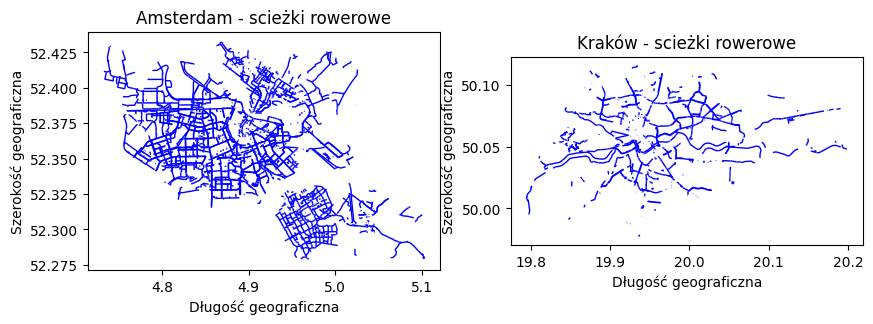

In [4]:
fig, axes = plt.subplots(1,2, figsize = [10, 10])
gdf_ams.plot(ax = axes[0], linewidth = 1, edgecolor = 'blue')

axes[0].set_title('Amsterdam - scieżki rowerowe')
axes[0].set_xlabel('Długość geograficzna')
axes[0].set_ylabel('Szerokość geograficzna')

gdf_krk.plot(ax = axes[1], linewidth = 1, edgecolor = 'blue')

axes[1].set_title('Kraków - scieżki rowerowe')
axes[1].set_xlabel('Długość geograficzna')
axes[1].set_ylabel('Szerokość geograficzna')

In [5]:
# Generowanie heksagonów H3 na obszarze Amsterdamu
def create_h3_hex_grid(df,bounds,epsg=4326):
    resolution = 8  # Rezolucja H3, im wyższa liczba, tym mniejsze heksagony
    buffer = 0.01
    h3_indices = h3.polyfill(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [bounds["west"], bounds["north"]],
                    [bounds["east"], bounds["north"]],
                    [bounds["east"], bounds["south"]],
                    [bounds["west"], bounds["south"]],
                    [bounds["west"], bounds["north"]],
                ]
            ],
        },
        resolution,
    )
    
    # Konwersja H3 do GeoDataFrame
    hexagons = []
    for h in h3_indices:
        hex_boundary = h3.h3_to_geo_boundary(h, geo_json=True)
        hex_boundary = [(lng, lat) for lat, lng in hex_boundary]
        hex_boundary.append(hex_boundary[0])  # Zamknięcie obwodu heksagonu
        hexagons.append({
            'geometry': Polygon(hex_boundary),
            'h3_index': h
        })
    
    gdf_hex = gpd.GeoDataFrame(hexagons)
    gdf_hex = gdf_hex.set_crs(epsg=epsg)
    
    return gdf_hex
 
# Funkcja przypisująca ścieżki rowerowe do heksagonów
def assign_hexagon(geometry, resolution):
    centroid = geometry.centroid
    return h3.geo_to_h3(centroid.y, centroid.x, resolution)



## Siatka hex z mapą

In [7]:
#Współrzędne granic Amsterdamu i Krakowa
amsterdam_bounds = {"north": 52.441157,"south": 52.2688,"east": 5.1127658,"west": 4.728073}
cracow_bounds = {"north":50.1257,"south":49.9639,"east": 20.215,"west":19.7946}

gdf_ams['h3_index'] = gdf_ams['geometry'].apply(assign_hexagon, resolution=8)
gdf_krk['h3_index'] = gdf_krk['geometry'].apply(assign_hexagon, resolution=8)


gdf_krk_hex = create_h3_hex_grid(gdf_krk,cracow_bounds)    
gdf_ams_hex = create_h3_hex_grid(gdf_ams,amsterdam_bounds)    

amsterdam_area = ox.geocode_to_gdf('Amsterdam, Netherlands')
cracow_area = ox.geocode_to_gdf('Kraków')




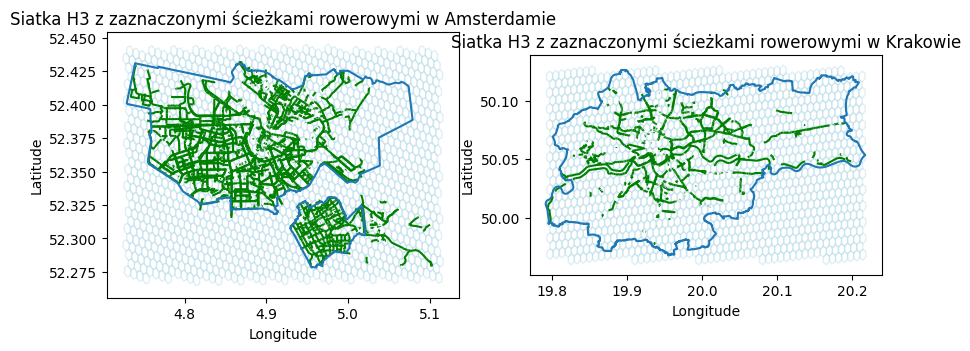

In [8]:
# Wizualizacja
fig, ax = plt.subplots(1,2,figsize=(10, 10))
gdf_ams_hex.plot(ax=ax[0], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_ams.plot(ax=ax[0], color='green')
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ax[0].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk_hex.plot(ax=ax[1], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_krk.plot(ax=ax[1], color='green')
cracow_area['geometry'].boundary.plot(ax=ax[1])

ax[1].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

## Przycięcie map i heksagonów

In [9]:

import warnings
warnings.filterwarnings('ignore') 

def crop_hex_grid(gdf_hex,gdf_bike,gdf_area,epsg):
    gdf_bike = gdf_bike.to_crs(epsg=epsg)
    gdf_hex = gdf_hex.to_crs(epsg=epsg)
    gdf_area = gdf_area.to_crs(epsg=epsg)
    gdf_hex['bike_path_length'] = 0.0
    gdf_hex['within_city'] = False

    for i, polygon in gdf_hex.iterrows():
        clipped = gdf_bike.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(gdf_area.geometry)
        gdf_hex.loc[i,'bike_path_length'] = clipped.length.sum()
        gdf_hex.loc[i,'within_city'] = within_city[0]

    gdf_hex = gdf_hex[(gdf_hex['within_city'] == True) | (gdf_hex['bike_path_length'] > 0)]
    gdf_hex = gdf_hex.to_crs(epsg=4326)
    del gdf_hex['within_city']
    
    return gdf_hex

gdf_ams_hex = crop_hex_grid(gdf_ams_hex, gdf_ams, amsterdam_area, 2180)
gdf_krk_hex = crop_hex_grid(gdf_krk_hex, gdf_krk, cracow_area, 2180)


Text(492.9494949494949, 0.5, 'Latitude')

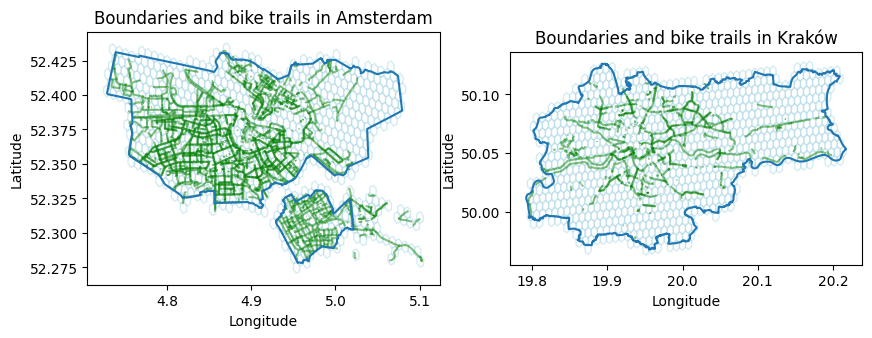

In [10]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
# Set plot title and labels
ax[0].set_title('Boundaries and bike trails in Amsterdam')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
cracow_area['geometry'].boundary.plot(ax=ax[1])
# Set plot title and labels
ax[1].set_title('Boundaries and bike trails in Kraków')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

## Hex razem z policzoną długością ścieżki rowerowej

In [11]:
gdf_ams_hex

,geometry,h3_index,bike_path_length
2,"POLYGON ((5.00400 52.41778, 5.00797 52.41898, ...",887ab64663fffff,267.786371
6,"POLYGON ((5.00485 52.35422, 5.00883 52.35542, ...",887ab646ddfffff,1565.754433
7,"POLYGON ((5.05789 52.41807, 5.06186 52.41927, ...",887ab64465fffff,0.000000
10,"POLYGON ((5.02035 52.42669, 5.02432 52.42789, ...",887ab64753fffff,0.000000
11,"POLYGON ((4.79253 52.42195, 4.79652 52.42314, ...",887ab6184dfffff,365.290379
...,...,...,...
1385,"POLYGON ((5.06848 52.40930, 5.07246 52.41050, ...",887ab6442dfffff,0.000000
1386,"POLYGON ((4.89303 52.42425, 4.89701 52.42544, ...",887ab6568bfffff,1006.915278
1387,"POLYGON ((4.77611 52.41302, 4.78011 52.41422, ...",887ab61a3dfffff,0.000000
1388,"POLYGON ((4.79019 52.36538, 4.79418 52.36658, ...",887ab61a87fffff,2366.517927


In [12]:
gdf_krk_hex

,geometry,h3_index,bike_path_length
0,"POLYGON ((20.05204 50.04268, 20.04802 50.04004...",885262c2cdfffff,1087.885309
1,"POLYGON ((19.85810 50.08185, 19.85408 50.07922...",885262ccc9fffff,0.000000
2,"POLYGON ((20.12046 50.08287, 20.11644 50.08023...",885262d46dfffff,0.000000
3,"POLYGON ((19.91048 50.09308, 19.90646 50.09045...",885262cecbfffff,0.000000
6,"POLYGON ((19.92303 50.00446, 19.91900 50.00182...",885262c1b1fffff,0.000000
...,...,...,...
1210,"POLYGON ((19.89855 50.05763, 19.89453 50.05500...",885262ce3bfffff,449.810086
1211,"POLYGON ((19.91896 50.01102, 19.91493 50.00839...",885262c1b3fffff,0.000000
1212,"POLYGON ((19.91509 49.97619, 19.91106 49.97356...",885262ca9bfffff,0.000000
1213,"POLYGON ((19.85829 50.04052, 19.85427 50.03789...",885262cc01fffff,1173.781588
